# COCO Instance Segmentation

COCO is a large image dataset designed for object detection, segmentation, person keypoints detection, stuff segmentation, and caption generation. We will focus on instance segmentation, i.e. distinguishing each category, giving different labels for individual instances in the same type of objects. It can be regarded as delivering the tasks of object detection and semantic segmentation at the same time. We will be using GPU of Hyperion server of City, University of London. Data is pre-downloaded from https://www.kaggle.com/datasets/awsaf49/coco-2017-dataset to Hyperion under directory '/mnt/data/public/coco2017'. Data original source: https://cocodataset.org/

In [1]:
!pip install pycocotools
from pycocotools.coco import COCO
import cython
from torch.utils import data
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch, torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.ops.boxes import box_convert

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

device = torch.device('cpu')
if torch.cuda.is_available():
   device = torch.device('cuda')

print(device)

Defaulting to user installation because normal site-packages is not writeable
cuda


## Check Dataset File Structure

In [2]:
path = '/mnt/data/public/coco2017/coco2017'

files = os.listdir(path)

for f in files:
	print(f)

annotations
test2017
train2017
val2017


In [3]:
path_a = path + '/annotations'

files = os.listdir(path_a)

for f in files:
	print(f)

person_keypoints_val2017.json
instances_val2017.json
person_keypoints_train2017.json
instances_train2017.json
captions_val2017.json
captions_train2017.json


## Check Categories

In [4]:
annotations_file='/mnt/data/public/coco2017/coco2017/annotations/instances_train2017.json' #file of coco dataset annotations 

# Initialize the COCO api for instance annotations
coco_train=COCO(annotations_file)

# Load the categories in a variable
catIDs = coco_train.getCatIds()
cats = coco_train.loadCats(catIDs)

print(cats)

loading annotations into memory...
Done (t=13.12s)
creating index...
index created!
[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': 'animal', 'id': 17, '

We can see that the category id of person is 1.

Let's see the number of images for each category.

In [5]:
for i in range(80):
    print('{} - category id: {}, count of training images: {}'.format(cats[i]['name'], cats[i]['id'], len(coco_train.getImgIds(catIds=[i]))))

person - category id: 1, count of training images: 0
bicycle - category id: 2, count of training images: 64115
car - category id: 3, count of training images: 3252
motorcycle - category id: 4, count of training images: 12251
airplane - category id: 5, count of training images: 3502
bus - category id: 6, count of training images: 2986
train - category id: 7, count of training images: 3952
truck - category id: 8, count of training images: 3588
boat - category id: 9, count of training images: 6127
traffic light - category id: 10, count of training images: 3025
fire hydrant - category id: 11, count of training images: 4139
stop sign - category id: 13, count of training images: 1711
parking meter - category id: 14, count of training images: 0
bench - category id: 15, count of training images: 1734
bird - category id: 16, count of training images: 705
cat - category id: 17, count of training images: 5570
dog - category id: 18, count of training images: 3237
horse - category id: 19, count of 

# Mask R-CNN
The code for mask R-CNN uses torchvision model, and is largely based on official tutorial from pytorch.org on finetuning mask R-CNN, with customization to the server environment (i.e. its absence of direct access to Internet) and our use case.

Reference:
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html and Lecture notes, INM705 DEEP LEARNING FOR IMAGE ANALYSIS - Lab5 by Dr Alex Ter-Sarkisov@City, University of London

From https://github.com/pytorch/vision.git, pre-download engine.py, utlis.py, transform.py (and they depend on coco_eval.py, coco_utlis.py, so they also need to be downloaded)

Let's see one of the images.

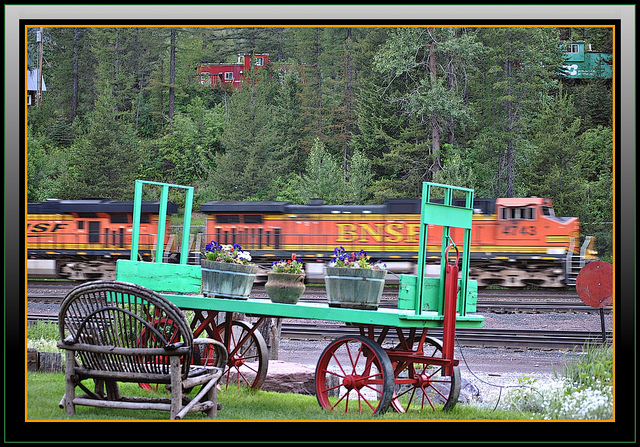

In [6]:
from PIL import Image
Image.open(path+'/test2017/000000112691.jpg')

# Finetuning from a pretrained model

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO; need to download weights manually beforehand as Hyperion is not connected to internet directly
# Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth"
# Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth"
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False,)
pretrained_weights = torch.load('fasterrcnn_resnet50_fpn_coco-258fb6c6.pth', map_location='cpu')
# # copy only backbone weights
for _n, _par in model.state_dict().items():
     if 'backbone' in _n:
        _par.requires_grad = False
        _par.copy_(pretrained_weights[_n])
        _par.requires_grad = True

if device == torch.device('cuda'):
    model = model.to(device)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

## Helper function

In [8]:
#import python modules downloaded from pytorch github https://github.com/pytorch/vision/tree/main/references/detection  
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

## Explore annotations

Lets's explore the annotations and data structure a bit before creating the dataset.

In [9]:
AnnIds = coco_train.getAnnIds(catIds=[16, 5], areaRng=[], iscrowd=False)
anns_obj1 = coco_train.loadAnns(AnnIds)
print(anns_obj1[0])
anns_obj2 = [ann for ann in anns_obj1 if len(coco_train.annToMask(ann)) > 0]  #remove empty mask
print(anns_obj2[0])

{'segmentation': [[390.68, 89.32, 378.88, 102.19, 345.64, 105.4, 337.06, 101.12, 314.54, 103.26, 313.47, 104.33, 323.12, 93.61, 331.7, 85.03, 341.35, 80.74, 353.15, 74.31, 356.36, 71.09, 367.09, 58.22, 385.32, 67.87, 405.69, 77.52, 415.35, 73.23, 419.64, 70.02, 433.58, 58.22, 461.46, 57.15, 467.89, 62.51, 472.18, 62.51, 453.95, 67.87, 434.65, 70.02, 427.14, 76.45, 419.64, 82.88, 411.06, 87.17, 404.62, 88.25, 392.83, 88.25]], 'area': 2887.0185999999994, 'iscrowd': 0, 'image_id': 202273, 'bbox': [313.47, 57.15, 158.71, 48.25], 'category_id': 16, 'id': 36262}
{'segmentation': [[390.68, 89.32, 378.88, 102.19, 345.64, 105.4, 337.06, 101.12, 314.54, 103.26, 313.47, 104.33, 323.12, 93.61, 331.7, 85.03, 341.35, 80.74, 353.15, 74.31, 356.36, 71.09, 367.09, 58.22, 385.32, 67.87, 405.69, 77.52, 415.35, 73.23, 419.64, 70.02, 433.58, 58.22, 461.46, 57.15, 467.89, 62.51, 472.18, 62.51, 453.95, 67.87, 434.65, 70.02, 427.14, 76.45, 419.64, 82.88, 411.06, 87.17, 404.62, 88.25, 392.83, 88.25]], 'area': 

In [10]:
len(anns_obj1)

15671

In [11]:
len(anns_obj2)

15671

It shows that it does not have empty mask for non-crowd and chosen category. Let's see the annotations and image object.

In [12]:
print(coco_train.annToMask(anns_obj1[0]))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [13]:
image_id = anns_obj1[0]['id']
img_obj = coco_train.loadImgs(image_id)[0]
print(img_obj['file_name'])

000000036262.jpg


In [14]:
anns_obj1[0]['bbox'][3]

48.25

In [15]:
img_obj

{'license': 3,
 'file_name': '000000036262.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000036262.jpg',
 'height': 313,
 'width': 500,
 'date_captured': '2013-11-19 18:53:35',
 'flickr_url': 'http://farm1.staticflickr.com/42/119341850_c0fe4f6151_z.jpg',
 'id': 36262}

# Define COCO dataset

While there are online examples of dataset codes, we need to customize to our needs by setting category to focus, excluding crowd for better data quality, and cleaning the data by removing those without mask annotations.

One note on the labels. The model considers class 0 as background. So we should avoid labeling any class as 0 if we don't have background. 

Let's focus on bird and airplane.



Let's deine COCO dataset class for dataloader of the model.

In [16]:
#inspired and adapt from reference below, with customization and correction
#reference: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
           #https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py
           #https://stackoverflow.com/questions/68513782/use-ms-coco-format-as-input-to-pytorch-maskrcnn
           #Lecture notes, INM705 DEEP LEARNING FOR IMAGE ANALYSIS - Lab5 by Dr. Alex Ter-Sarkisov @ City, University of London

dataset_dir='/mnt/data/public/coco2017/coco2017'
focus_category = [16, 5]   #16: bird category; 5: airplane

class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dir, subset='train', transforms=None, focus_category=focus_category, areaRng=[], iscrowd=False):
        ann_file = '{}/annotations/instances_{}2017.json'.format(dataset_dir, subset)
        self.imgs_dir = os.path.join(dataset_dir, subset+'2017')
        self.coco = COCO(ann_file)
        AnnIds = self.coco.getAnnIds(catIds=focus_category, areaRng=areaRng, iscrowd=iscrowd)
        self.anns_obj = self.coco.loadAnns(AnnIds)
        self.image_id_all = [ ann['image_id'] for ann in self.anns_obj ]
        self.image_id_all = np.unique(np.array(self.image_id_all, dtype=int))
        self.catlabel = {}
        for i in range(len(focus_category)):
            self.catlabel[focus_category[i]] = i +1   #note: lable 0 reserved for background category in the model
        self.transforms = transforms
        self.focus_category = focus_category
        self.areaRng = areaRng
        self.iscrowd = iscrowd
        

        
    def __len__(self):
        self.length = len(self.image_id_all)
        return self.length  

    def mabic(self, ann, masks, areas, boxes, image_id_instance, catIds):
        #print('ann type: {}; ann: {}'.format(type(ann),ann))
        #print('ann area: {}'.format(ann['area']))
        areas.append(ann['area'])
        masks.append(self.coco.annToMask(ann))
        #1e-7 solves float num rounding issue
        boxes.append([ann['bbox'][0], ann['bbox'][1], ann['bbox'][0]+ann['bbox'][2]+1e-11, ann['bbox'][1]+ann['bbox'][3]+1e-11]) 
        image_id_instance.append(ann['image_id'])
        catIds.append(ann['category_id'])
        return masks, areas, boxes, image_id_instance, catIds
    
    def __getitem__(self, idx):
        '''
        Args:
            idx: index of sample to be fed
        return:
            dict containing:
            - PIL Image of shape (H, W)
            - target (dict) containing: 
                - boxes:    FloatTensor[N, 4], N being the n° of instances and it's bounding 
                boxe coordinates in [x0, y0, x1, y1] format, ranging from 0 to W and 0 to H;
                - labels:   Int64Tensor[N], class label (0 is background);
                - image_id: Int64Tensor[1], unique id for each image;
                - area:     Tensor[N], area of bbox;
                - iscrowd:  UInt8Tensor[N], True or False;
                - masks:    UInt8Tensor[N, H, W], segmantation maps;
        '''
    
        #get image id and then get annotation object
        image_id = self.image_id_all[idx]
        AnnIds = self.coco.getAnnIds(imgIds = image_id, catIds=self.focus_category, areaRng=self.areaRng, iscrowd=self.iscrowd)
        anns = self.coco.loadAnns(AnnIds)  
 
        # fix old format issue: convert [xmin, ymin, width, height] in pycocotools to [xmin, ymin, xmax, ymax] format required by model
        boxes=[]
        masks=[]
        areas=[]
        image_id_instance=[]
        catIds=[]
        

        #print('AnnIds: {}'.format(AnnIds))   
        #if len(AnnIds) == 1:
            #print('type of annotation object anns:{}'.format(type(anns)))
            #print('------------------'+str(type(anns))+'-------------------')
            
        #if isinstance(AnnIds, int):
            #masks, areas, boxes, image_id_instance, catIds = self.mabic(anns, masks, areas, boxes, image_id_instance, catIds)
        #elif len(AnnIds) == 1:
            #masks, areas, boxes, image_id_instance, catIds = self.mabic(anns, masks, areas, boxes, image_id_instance, catIds)
        #else:
        for ann in anns: 
            masks, areas, boxes, image_id_instance, catIds = self.mabic(ann, masks, areas, boxes, image_id_instance, catIds)
        
 
        #get image for return
        if type(image_id) == np.int64:
            image_id = image_id.item()           #convert numpy integer to python native integer for loadImgs
        img_obj = self.coco.loadImgs(image_id)[0]
        img = Image.open(os.path.join(self.imgs_dir, img_obj['file_name']))
        if self.transforms is not None:
            img = self.transforms(img)
        
        #note: label 0 is reserved for background in the model
        #print('catlabel: {}; catIds: {}'.format(self.catlabel, catIds))
        labels = [ self.catlabel[i] for i in catIds]
        
        labels = torch.as_tensor(labels, dtype=torch.int64)   
        iscrowd = torch.zeros(len(anns), dtype=torch.int64) #because we have excluded crowd
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)  #empty box causes error, reshape from 0 to (0,4) for empty box
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)
        image_id_instance = torch.tensor(image_id_instance)
        area = torch.as_tensor(areas)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = torch.tensor(image_id)    # not asking for image_id_instance
        target["area"] = area
        target["iscrowd"] = iscrowd

        return img, target


# Instance segmentation model

In [17]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False,  pretrained_backbone=False,)
    pretrained_weights = torch.load('maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth', map_location='cpu')
    # # copy only backbone weights
    for _n, _par in model.state_dict().items():
         if 'backbone' in _n:
            _par.requires_grad = False
            _par.copy_(pretrained_weights[_n])
            _par.requires_grad = True

    if device == torch.device('cuda'):
        model = model.to(device)
    
    
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

## Putting everything together

In [18]:
# use our dataset and defined transformations
import torchvision.transforms as transforms
dataset = CocoDataset('/mnt/data/public/coco2017/coco2017', 'train', transforms.Compose([transforms.ToTensor()]))
dataset_test = CocoDataset('/mnt/data/public/coco2017/coco2017', 'val', transforms.Compose([transforms.ToTensor()]))

# split the dataset in train and test set
torch.manual_seed(1)
#indices = torch.randperm(len(dataset)).tolist()
#dataset = torch.utils.data.Subset(dataset, indices[:-50])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=8, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

loading annotations into memory...
Done (t=18.96s)
creating index...
index created!
loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


## Instantiate the model and optimizer

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background, bird, airplane
num_classes = 3

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

## Training

In [20]:
# let's train it for 2 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 1
y =[]
for epoch in range(num_epochs):
    # train for one epoch, printing every 100 iterations
    x,y = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    
    z = evaluate(model, data_loader_test, device=device)

/opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/775]  eta: 0:30:30  lr: 0.000011  loss: 4.7815 (4.7815)  loss_classifier: 1.0456 (1.0456)  loss_box_reg: 0.0318 (0.0318)  loss_mask: 2.9951 (2.9951)  loss_objectness: 0.6746 (0.6746)  loss_rpn_box_reg: 0.0345 (0.0345)  time: 2.3615  data: 0.9133  max mem: 15453
Epoch: [0]  [100/775]  eta: 0:05:12  lr: 0.000657  loss: 0.8881 (1.7727)  loss_classifier: 0.1291 (0.3286)  loss_box_reg: 0.1002 (0.0863)  loss_mask: 0.4562 (0.8773)  loss_objectness: 0.0963 (0.3957)  loss_rpn_box_reg: 0.0417 (0.0848)  time: 0.4527  data: 0.0195  max mem: 18739
Epoch: [0]  [200/775]  eta: 0:04:22  lr: 0.001302  loss: 0.7356 (1.3010)  loss_classifier: 0.1075 (0.2343)  loss_box_reg: 0.1288 (0.1161)  loss_mask: 0.3487 (0.6288)  loss_objectness: 0.0743 (0.2441)  loss_rpn_box_reg: 0.0469 (0.0777)  time: 0.4739  data: 0.0198  max mem: 18742
Epoch: [0]  [300/775]  eta: 0:03:36  lr: 0.001948  loss: 0.6612 (1.0965)  loss_classifier: 0.0987 (0.1928)  loss_box_reg: 0.1201 (0.1225)  loss_mask: 0.3278 (0.534

In [21]:
dataset.__len__()

6198

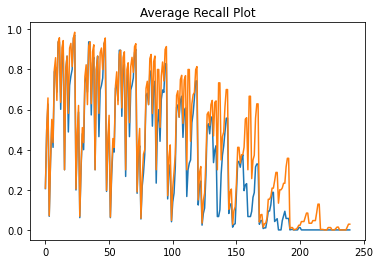

In [22]:
import matplotlib.pyplot as plt
import numpy as np

p = z.coco_eval["segm"].eval["recall"]
s = z.coco_eval["bbox"].eval["recall"]

p = p.reshape(-1)
s = s.reshape(-1)

    #ps = z.coco_eval["bbox"].eval["recall"]
plt.title("Average Recall Plot")
plt.plot(p)
plt.plot(s)

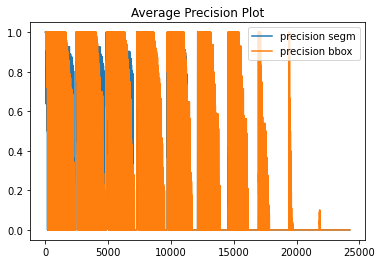

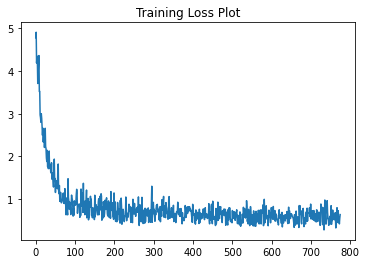

In [23]:
p=[]
s=[]

p = z.coco_eval["segm"].eval["precision"]
s = z.coco_eval["bbox"].eval["precision"]
plt.title("Average Precision Plot")
    #ps = z.coco_eval["bbox"].eval["recall"]
p = p.reshape(-1)
s = s.reshape(-1)
plt.plot(p)
plt.plot(s)
plt.legend(['precision segm', 'precision bbox'])
plt.show()
    
plt.title("Training Loss Plot")
plt.plot(y)
plt.show()

In [24]:
for x , y in data_loader_test:
    print(y[0]["labels"].size())
print(y[0]["labels"].size())

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([13])
torch.Size([1])
torch.Size([1])
torch.Size([2])
torch.Size([1])
torch.Size([2])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([2])
torch.Size([4])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([2])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([2])
torch.Size([4])
torch.Size([1])
torch.Size([1])
torch.Size([4])
torch.Size([4])


In [25]:
def confusionmatrix(predictions,test_loader):
    num_correct = 0
    num_samples = 0
    for x , y in test_loader:
       

        conf_m = confusion_matrix(y, predictions)
        conf_m = pd.DataFrame(conf_m)
        plt.figure(figsize = (10,7))
        sns.heatmap(conf_m, annot=True)

In [26]:
prediction[0]["labels"]

NameError: name 'prediction' is not defined

In [ ]:

plt.plot(y)
plt.show()

In [ ]:
dataset.image_id_all

In [ ]:
prediction[0]["labels"].size()

## Prediction

In [ ]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
    
prediction

Convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in [C, H, W] format.

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

Let's now visualize the top predicted segmentation mask. The masks are predicted as [N, 1, H, W], where N is the number of predictions, and are probability maps between 0-1.

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

# Qualitative Analysis

CHanged the hidden layer from 256 to 128

In [27]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False,  pretrained_backbone=False,)
    pretrained_weights = torch.load('maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth', map_location='cpu')
    # # copy only backbone weights
    for _n, _par in model.state_dict().items():
         if 'backbone' in _n:
            _par.requires_grad = False
            _par.copy_(pretrained_weights[_n])
            _par.requires_grad = True

    if device == torch.device('cuda'):
        model = model.to(device)
    
    
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer =128
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [28]:
# use our dataset and defined transformations
import torchvision.transforms as transforms
dataset = CocoDataset('/mnt/data/public/coco2017/coco2017', 'train', transforms.Compose([transforms.ToTensor()]))
dataset_test = CocoDataset('/mnt/data/public/coco2017/coco2017', 'val', transforms.Compose([transforms.ToTensor()]))

# split the dataset in train and test set
torch.manual_seed(1)
#indices = torch.randperm(len(dataset)).tolist()
#dataset = torch.utils.data.Subset(dataset, indices[:-50])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=8, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

loading annotations into memory...
Done (t=19.20s)
creating index...
index created!
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background, bird, airplane
num_classes = 3

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [30]:
# let's train it for 2 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 2
y =[]
for epoch in range(num_epochs):
    # train for one epoch, printing every 100 iterations
    x,y = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    z = evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/775]  eta: 0:17:15  lr: 0.000011  loss: 4.1348 (4.1348)  loss_classifier: 1.0420 (1.0420)  loss_box_reg: 0.0276 (0.0276)  loss_mask: 2.2316 (2.2316)  loss_objectness: 0.6772 (0.6772)  loss_rpn_box_reg: 0.1564 (0.1564)  time: 1.3355  data: 0.8389  max mem: 18744
Epoch: [0]  [100/775]  eta: 0:05:17  lr: 0.000657  loss: 0.8678 (1.6747)  loss_classifier: 0.1394 (0.3256)  loss_box_reg: 0.1204 (0.0957)  loss_mask: 0.4378 (0.7729)  loss_objectness: 0.1035 (0.3907)  loss_rpn_box_reg: 0.0513 (0.0898)  time: 0.4602  data: 0.0199  max mem: 18744
Epoch: [0]  [200/775]  eta: 0:04:25  lr: 0.001302  loss: 0.7615 (1.2365)  loss_classifier: 0.1085 (0.2293)  loss_box_reg: 0.1129 (0.1167)  loss_mask: 0.3536 (0.5759)  loss_objectness: 0.0585 (0.2382)  loss_rpn_box_reg: 0.0277 (0.0765)  time: 0.4477  data: 0.0202  max mem: 18744
Epoch: [0]  [300/775]  eta: 0:03:37  lr: 0.001948  loss: 0.6740 (1.0653)  loss_classifier: 0.0981 (0.1914)  loss_box_reg: 0.1426 (0.1266)  loss_mask: 0.3350 (0.500

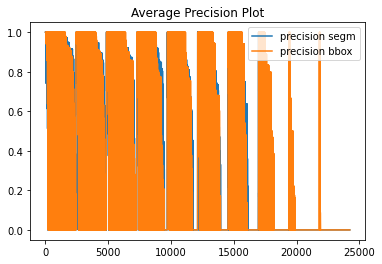

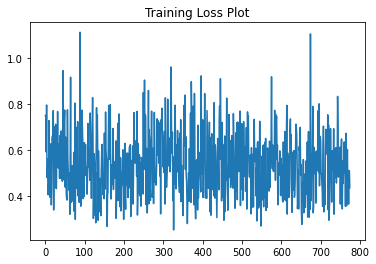

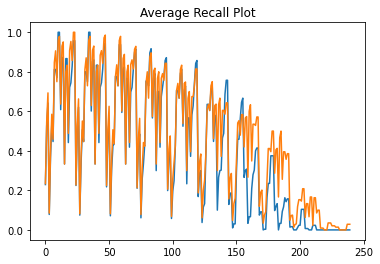

In [31]:
import matplotlib.pyplot as plt
import numpy as np

p=[]
s=[]

p = z.coco_eval["segm"].eval["precision"]
s = z.coco_eval["bbox"].eval["precision"]
plt.title("Average Precision Plot")
    #ps = z.coco_eval["bbox"].eval["recall"]
p = p.reshape(-1)
s = s.reshape(-1)
plt.plot(p)
plt.plot(s)
plt.legend(['precision segm', 'precision bbox'])
plt.show()
    
plt.title("Training Loss Plot")
plt.plot(y)
plt.show()

p = z.coco_eval["segm"].eval["recall"]
s = z.coco_eval["bbox"].eval["recall"]

p = p.reshape(-1)
s = s.reshape(-1)

    #ps = z.coco_eval["bbox"].eval["recall"]
plt.title("Average Recall Plot")
plt.plot(p)
plt.plot(s)




Changed Gamma value from 0.1 to 0.9

In [32]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background, bird, airplane
num_classes = 3

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.9)

In [34]:
# let's train it for 2 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 2
y=[]
for epoch in range(num_epochs):
    # train for one epoch, printing every 100 iterations
    x,y = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    z = evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/775]  eta: 0:19:00  lr: 0.000001  loss: 1.2367 (1.2367)  loss_classifier: 0.1742 (0.1742)  loss_box_reg: 0.0854 (0.0854)  loss_mask: 0.5656 (0.5656)  loss_objectness: 0.3454 (0.3454)  loss_rpn_box_reg: 0.0660 (0.0660)  time: 1.4719  data: 0.9239  max mem: 18748
Epoch: [0]  [100/775]  eta: 0:05:00  lr: 0.000051  loss: 1.0950 (1.2252)  loss_classifier: 0.1188 (0.1399)  loss_box_reg: 0.0808 (0.1069)  loss_mask: 0.5372 (0.5686)  loss_objectness: 0.2767 (0.3254)  loss_rpn_box_reg: 0.0405 (0.0844)  time: 0.4237  data: 0.0179  max mem: 18748
Epoch: [0]  [200/775]  eta: 0:04:19  lr: 0.000100  loss: 0.9585 (1.1413)  loss_classifier: 0.1433 (0.1424)  loss_box_reg: 0.1183 (0.1125)  loss_mask: 0.4819 (0.5443)  loss_objectness: 0.1404 (0.2613)  loss_rpn_box_reg: 0.0403 (0.0808)  time: 0.4436  data: 0.0205  max mem: 18748
Epoch: [0]  [300/775]  eta: 0:03:34  lr: 0.000150  loss: 0.8920 (1.0642)  loss_classifier: 0.1483 (0.1406)  loss_box_reg: 0.1332 (0.1149)  loss_mask: 0.4269 (0.511

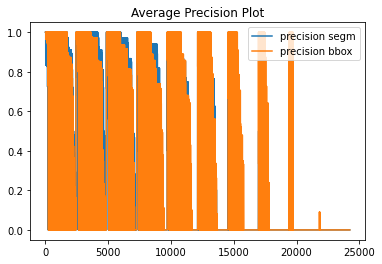

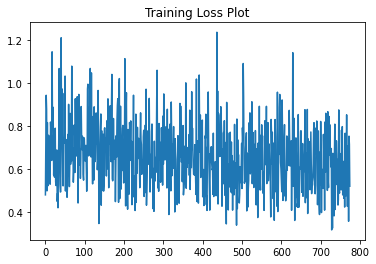

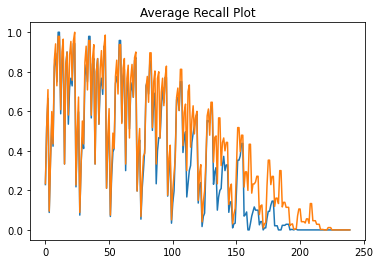

In [36]:
import matplotlib.pyplot as plt
import numpy as np

p=[]
s=[]

p = z.coco_eval["segm"].eval["precision"]
s = z.coco_eval["bbox"].eval["precision"]
plt.title("Average Precision Plot")
    #ps = z.coco_eval["bbox"].eval["recall"]
p = p.reshape(-1)
s = s.reshape(-1)
plt.plot(p)
plt.plot(s)
plt.legend(['precision segm', 'precision bbox'])
plt.show()
    
plt.title("Training Loss Plot")
plt.plot(y)
plt.show()

p = z.coco_eval["segm"].eval["recall"]
s = z.coco_eval["bbox"].eval["recall"]

p = p.reshape(-1)
s = s.reshape(-1)

    #ps = z.coco_eval["bbox"].eval["recall"]
plt.title("Average Recall Plot")
plt.plot(p)
plt.plot(s)




Changed Gamma value from 0.1 to 0.3

In [37]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background, bird, airplane
num_classes = 3

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.3)

In [38]:
# let's train it for 2 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 2
y=[]
x=[]
z=[]
for epoch in range(num_epochs):
    # train for one epoch, printing every 100 iterations
    x,y = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    z = evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/775]  eta: 0:15:29  lr: 0.000011  loss: 3.5266 (3.5266)  loss_classifier: 1.0386 (1.0386)  loss_box_reg: 0.0110 (0.0110)  loss_mask: 1.7403 (1.7403)  loss_objectness: 0.7164 (0.7164)  loss_rpn_box_reg: 0.0203 (0.0203)  time: 1.1993  data: 0.8240  max mem: 18782
Epoch: [0]  [100/775]  eta: 0:05:09  lr: 0.000657  loss: 0.8706 (1.6472)  loss_classifier: 0.1282 (0.3094)  loss_box_reg: 0.1151 (0.0760)  loss_mask: 0.4338 (0.7585)  loss_objectness: 0.0904 (0.4222)  loss_rpn_box_reg: 0.0298 (0.0810)  time: 0.4550  data: 0.0189  max mem: 19276
Epoch: [0]  [200/775]  eta: 0:04:17  lr: 0.001302  loss: 0.7817 (1.2283)  loss_classifier: 0.1216 (0.2188)  loss_box_reg: 0.1311 (0.1032)  loss_mask: 0.3521 (0.5742)  loss_objectness: 0.0586 (0.2561)  loss_rpn_box_reg: 0.0323 (0.0760)  time: 0.4506  data: 0.0193  max mem: 19276
Epoch: [0]  [300/775]  eta: 0:03:32  lr: 0.001948  loss: 0.6099 (1.0652)  loss_classifier: 0.0934 (0.1856)  loss_box_reg: 0.1291 (0.1189)  loss_mask: 0.3162 (0.498

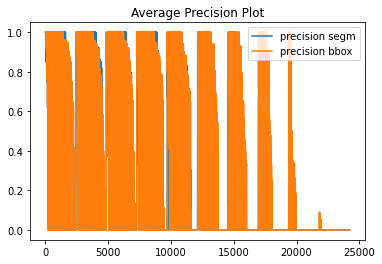

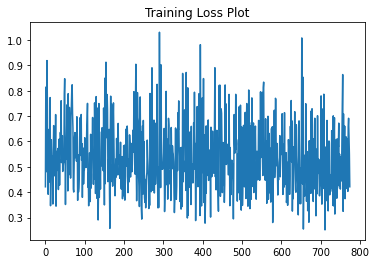

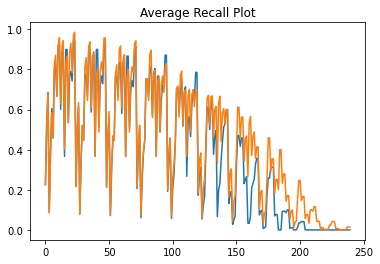

In [39]:
import matplotlib.pyplot as plt
import numpy as np

p=[]
s=[]

p = z.coco_eval["segm"].eval["precision"]
s = z.coco_eval["bbox"].eval["precision"]
plt.title("Average Precision Plot")
    #ps = z.coco_eval["bbox"].eval["recall"]
p = p.reshape(-1)
s = s.reshape(-1)
plt.plot(p)
plt.plot(s)
plt.legend(['precision segm', 'precision bbox'])
plt.show()
    
plt.title("Training Loss Plot")
plt.plot(y)
plt.show()

p = z.coco_eval["segm"].eval["recall"]
s = z.coco_eval["bbox"].eval["recall"]

p = p.reshape(-1)
s = s.reshape(-1)

    #ps = z.coco_eval["bbox"].eval["recall"]
plt.title("Average Recall Plot")
plt.plot(p)
plt.plot(s)




changed the Optimizer from SGD to Adam

In [42]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background, bird, airplane
num_classes = 3

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params,lr=0.005,betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)


# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.3)

In [43]:
# let's train it for 2 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 2
y=[]
x=[]
z=[]
for epoch in range(num_epochs):
    # train for one epoch, printing every 100 iterations
    x,y = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    z = evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/775]  eta: 0:17:20  lr: 0.000011  loss: 3.5370 (3.5370)  loss_classifier: 1.0896 (1.0896)  loss_box_reg: 0.0061 (0.0061)  loss_mask: 1.6098 (1.6098)  loss_objectness: 0.6963 (0.6963)  loss_rpn_box_reg: 0.1352 (0.1352)  time: 1.3430  data: 0.8743  max mem: 19284
Epoch: [0]  [100/775]  eta: 0:05:09  lr: 0.000657  loss: 0.8392 (1.1066)  loss_classifier: 0.1453 (0.1842)  loss_box_reg: 0.1177 (0.1030)  loss_mask: 0.4598 (0.5652)  loss_objectness: 0.0745 (0.1881)  loss_rpn_box_reg: 0.0304 (0.0661)  time: 0.4507  data: 0.0194  max mem: 19451
Epoch: [0]  [200/775]  eta: 0:04:20  lr: 0.001302  loss: 0.8451 (1.0213)  loss_classifier: 0.1115 (0.1546)  loss_box_reg: 0.0827 (0.0978)  loss_mask: 0.5003 (0.5307)  loss_objectness: 0.1038 (0.1655)  loss_rpn_box_reg: 0.0602 (0.0727)  time: 0.4273  data: 0.0194  max mem: 19451
Epoch: [0]  [300/775]  eta: 0:03:33  lr: 0.001948  loss: 0.9734 (0.9896)  loss_classifier: 0.1044 (0.1388)  loss_box_reg: 0.0623 (0.0888)  loss_mask: 0.6130 (0.534

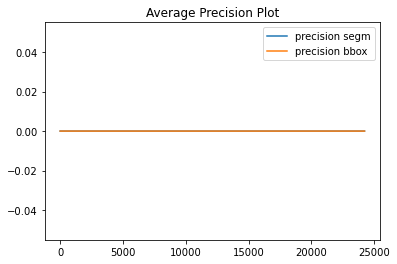

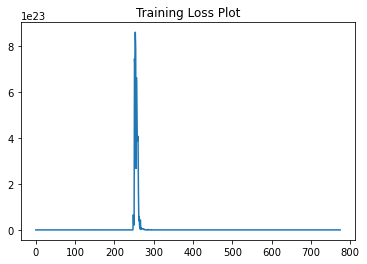

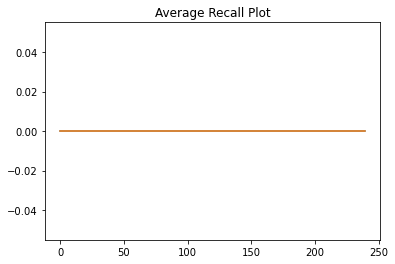

In [44]:
import matplotlib.pyplot as plt
import numpy as np

p=[]
s=[]

p = z.coco_eval["segm"].eval["precision"]
s = z.coco_eval["bbox"].eval["precision"]
plt.title("Average Precision Plot")
    #ps = z.coco_eval["bbox"].eval["recall"]
p = p.reshape(-1)
s = s.reshape(-1)
plt.plot(p)
plt.plot(s)
plt.legend(['precision segm', 'precision bbox'])
plt.show()
    
plt.title("Training Loss Plot")
plt.plot(y)
plt.show()

p = z.coco_eval["segm"].eval["recall"]
s = z.coco_eval["bbox"].eval["recall"]

p = p.reshape(-1)
s = s.reshape(-1)

    #ps = z.coco_eval["bbox"].eval["recall"]
plt.title("Average Recall Plot")
plt.plot(p)
plt.plot(s)




Running the model for best fit by increasing the epochs from 2 to 10

In [45]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False,  pretrained_backbone=False,)
    pretrained_weights = torch.load('maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth', map_location='cpu')
    # # copy only backbone weights
    for _n, _par in model.state_dict().items():
         if 'backbone' in _n:
            _par.requires_grad = False
            _par.copy_(pretrained_weights[_n])
            _par.requires_grad = True

    if device == torch.device('cuda'):
        model = model.to(device)
    
    
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer =128
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [46]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background, bird, airplane
num_classes = 3

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# let's train it for 2 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10
y=[]
x=[]
z=[]
for epoch in range(num_epochs):
    # train for one epoch, printing every 100 iterations
    x,y = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    z = evaluate(model, data_loader_test, device=device)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

p=[]
s=[]

p = z.coco_eval["segm"].eval["precision"]
s = z.coco_eval["bbox"].eval["precision"]
plt.title("Average Precision Plot")
    #ps = z.coco_eval["bbox"].eval["recall"]
p = p.reshape(-1)
s = s.reshape(-1)
plt.plot(p)
plt.plot(s)
plt.legend(['precision segm', 'precision bbox'])
plt.show()
    
plt.title("Training Loss Plot")
plt.plot(y)
plt.show()

p = z.coco_eval["segm"].eval["recall"]
s = z.coco_eval["bbox"].eval["recall"]

p = p.reshape(-1)
s = s.reshape(-1)

    #ps = z.coco_eval["bbox"].eval["recall"]
plt.title("Average Recall Plot")
plt.plot(p)
plt.plot(s)


